In [1]:
import pandas as pd
import numpy as np
import os
import csv
import shutil
from statistics import median, mean, stdev
from math import sqrt
import matplotlib.pyplot as plt

In [2]:
def get_combination(directory, name):
    combs = []
    data1 = open(f"./{directory}/{name}-1.csv").readlines()
    data2 = open(f"./{directory}/{name}-2.csv").readlines()
    data3 = open(f"./{directory}/{name}-3.csv").readlines()
    for i in range(len(data1)):
        temp1 = data1[i].strip().split()
        temp2 = data2[i].strip().split()
        temp3 = data3[i].strip().split()
        maxBw = max([int(float(temp1[2])), int(float(temp2[2])), int(float(temp3[2]))])//3
        key = f"consistency({maxBw}, {temp1[-1]}, {temp1[0]} {temp2[0]} {temp3[0]})"
        combs.append(key)
    return combs

In [3]:
def read_segmental(parent_path, path, num_app, mode, monitor_interval, isLatency):
    file_path = parent_path + path
    framesData = {"1": [], "2": [], "3":[]}
    reference = np.array([])
    for appNum in range(1,num_app+1):
        with open("%s-%d.csv" %(file_path, appNum), "r") as csv_file:
            data_reader = csv.reader(csv_file)
            for line in data_reader:
                data_temp = np.array(line, dtype=np.double)
                framesData[str(appNum)].append(data_temp)
        framesData[str(appNum)] = np.array(framesData[str(appNum)])
    return framesData

In [4]:
def read_f1_score(directory):
    # start = 0 if directory != "heatmap-dds_accSen-multi-5" else 118
    start = 0
    f1s = []
    data1 = open(f"./{directory}/f1Score-1.csv").readlines()
    data2 = open(f"./{directory}/f1Score-2.csv").readlines()
    data3 = open(f"./{directory}/f1Score-3.csv").readlines()
    for i in range(start, len(data1)):
        temp1 = data1[i].strip()
        temp2 = data2[i].strip()
        temp3 = data3[i].strip()
        average = sum([float(temp1), float(temp2), float(temp3)])/3
        f1s.append(average)
    return f1s

In [5]:
def process_data(combinations_inferDiff, f1s_inferDiff, combinations_10s, f1s_10s, combinations_fair, f1s_fair):
    inferDiffDict = {}
    fairAllocDict = {}
    first10sDict = {}
    for i in range(len(f1s_fair)):
        fairAllocDict[combinations_fair[i]] = f1s_fair[i]
    for i in range(len(f1s_10s)):
        first10sDict[combinations_10s[i]] = f1s_10s[i]
    for i in range(len(f1s_inferDiff)):
        if combinations_inferDiff[i] in inferDiffDict.keys():
            inferDiffDict[combinations_inferDiff[i]].append(f1s_inferDiff[i])
        else:
            inferDiffDict[combinations_inferDiff[i]] = [f1s_inferDiff[i]]
    for key in inferDiffDict.keys():
        inferDiffDict[key] = max(inferDiffDict[key])
        
    inferDiffDict_bw = {}
    fairAllocDict_bw = {}
    first10sDict_bw = {}
#     bandwidth = [str(i) for i in [3000, 4500, 5400, 6000]]
#     bandwidth = [str(i) for i in [1500, 3000, 4500, 5400]]
    bandwidth = [f"{i}" for i in range(900, 1500, 150)]
    for bw in bandwidth:
        for key in combinations_fair:
            if bw in key:
                if bw not in inferDiffDict_bw.keys():
                    inferDiffDict_bw[bw] = [inferDiffDict[key]]
                    fairAllocDict_bw[bw] = [fairAllocDict[key]]
                    first10sDict_bw[bw] = [first10sDict[key]]
                else:
                    inferDiffDict_bw[bw].append(inferDiffDict[key])
                    fairAllocDict_bw[bw].append(fairAllocDict[key])
                    first10sDict_bw[bw].append(first10sDict[key])
    for bw in bandwidth:
        inferDiffDict_bw[bw] = mean(inferDiffDict_bw[bw])
        fairAllocDict_bw[bw] = mean(fairAllocDict_bw[bw])
        first10sDict_bw[bw] = mean(first10sDict_bw[bw])
    return (inferDiffDict_bw, fairAllocDict_bw, first10sDict_bw)

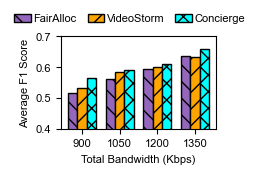

In [6]:
# DDS
# combinations_dds_inferDiff = get_combination("dds-inferdiff-cat-multi-4-80", "sanityCheck")
# f1s_dds_inferDiff = np.array(read_f1_score("dds-inferdiff-cat-multi-4-80"))
# combinations_10s = get_combination("baseline-cat-80", "sanityCheck")
# f1s_10s = np.array(read_f1_score("baseline-cat-80"))
# combinations_fair = get_combination("fair-alloc-cat-80", "sanityCheck")
# f1s_fair = np.array(read_f1_score("fair-alloc-cat-80"))

combinations_dds_inferDiff = get_combination("dds-new-cat-inferdiff", "sanityCheck")
f1s_dds_inferDiff = np.array(read_f1_score("dds-new-cat-inferdiff"))
combinations_10s = get_combination("dds-new-cat-baseline", "sanityCheck")
f1s_10s = np.array(read_f1_score("dds-new-cat-baseline"))
combinations_fair = get_combination("dds-new-cat-fairAlloc", "sanityCheck")
f1s_fair = np.array(read_f1_score("dds-new-cat-fairAlloc"))

# combinations_dds_inferDiff = get_combination("aws-new-cat-inferdiff", "sanityCheck")
# f1s_dds_inferDiff = np.array(read_f1_score("aws-new-cat-inferdiff"))
# combinations_10s = get_combination("aws-new-cat-baseline", "sanityCheck")
# f1s_10s = np.array(read_f1_score("aws-new-cat-baseline"))
# combinations_fair = get_combination("aws-new-cat-fairAlloc", "sanityCheck")
# f1s_fair = np.array(read_f1_score("aws-new-cat-fairAlloc"))

# AWStream
# combinations_aws_inferDiff = get_combination("aws_inferDiff-old-multi-5-50", "sanityCheck")
# f1s_aws_inferDiff = np.array(read_f1_score("aws_inferDiff-old-multi-5-50"))
# combinations_aws_10s = get_combination("aws_baseline-old-50", "sanityCheck")
# f1s_aws_10s = np.array(read_f1_score("aws_baseline-old-50"))
# combinations_aws_fair = get_combination("aws_fair-alloc-old-50", "sanityCheck")
# f1s_aws_fair = np.array(read_f1_score("aws_fair-alloc-old-50"))
# combinations_dds_inferDiff = get_combination("aws-inferdiff-cat-multi-5-80", "sanityCheck")
# f1s_dds_inferDiff = np.array(read_f1_score("aws-inferdiff-cat-multi-5-80"))
# combinations_10s = get_combination("aws-baseline-cat", "sanityCheck")
# f1s_10s = np.array(read_f1_score("aws-baseline-cat"))
# combinations_fair = get_combination("aws-fair-alloc-cat", "sanityCheck")
# f1s_fair = np.array(read_f1_score("aws-fair-alloc-cat"))

# Process DDS
dds_con, dds_fair, dds_10s = process_data(combinations_dds_inferDiff, f1s_dds_inferDiff, combinations_10s, f1s_10s, combinations_fair, f1s_fair)

# Process AWStream
# aws_con, aws_fair, aws_10s = process_data(combinations_aws_inferDiff, f1s_aws_inferDiff, combinations_aws_10s, f1s_aws_10s, combinations_aws_fair, f1s_aws_fair)

plt.rcParams.update({'font.size': 8})
plt.rcParams['font.sans-serif'] = "Arial"
_, axs = plt.subplots(figsize=(2, 1.2), sharey=True)
colors = ['#00FFFF', 'orange', 'tab:purple']
bandwidth = [f"{i}" for i in range(900, 1500, 150)]
# bandwidth = [f"{i}" for i in [3000, 4500, 5400, 6000]]
# bandwidth = [str(i) for i in [1500, 3000, 4500, 5400]]
X_axis = np.arange(len(bandwidth))
inferDiffDict_bw = dds_con
first10sDict_bw = dds_10s
fairAllocDict_bw = dds_fair
axs.bar(X_axis - 0.25, fairAllocDict_bw.values(), 0.25, color=colors[2], label = 'FairAlloc', hatch=['\\\\','\\\\','\\\\','\\\\'], edgecolor='k')
axs.bar(X_axis, first10sDict_bw.values(), 0.25, color=colors[1], label = 'VideoStorm', hatch=['//','//','//','//'], edgecolor='k')
axs.bar(X_axis + 0.25, inferDiffDict_bw.values(), 0.25, color=colors[0], label = 'Concierge', hatch=['xx','xx','xx','xx'], edgecolor='k')
axs.set_xticks(X_axis, bandwidth)
axs.set_xlabel("Total Bandwidth (Kbps)")
axs.set_ylabel("Average F1 Score")
plt.ylim([0.4, 0.7])
plt.legend(loc="upper right", bbox_to_anchor=(1.25, 1.35),ncol=3,frameon=False, handlelength=1.5, columnspacing=1, handletextpad=0.2)
plt.savefig("concierge-perf.pdf", bbox_inches='tight')
plt.show()

In [7]:
print((dds_con["900"] - dds_fair["900"]) / dds_fair["900"])
print((dds_con["900"] - dds_10s["900"]) / dds_10s["900"])

0.09566340256106731
0.06361642118458173


In [8]:
dds_fair

{'900': 0.5162777777777778,
 '1050': 0.5624444444444444,
 '1200': 0.5948333333333333,
 '1350': 0.6352777777777778}

In [9]:
dds_10s

{'900': 0.5318333333333333,
 '1050': 0.5843888888888888,
 '1200': 0.5997777777777777,
 '1350': 0.6318333333333334}

In [10]:
dds_con

{'900': 0.5656666666666667,
 '1050': 0.5893888888888889,
 '1200': 0.6092777777777778,
 '1350': 0.6581111111111111}